In [ ]:
!pip install datasets transformers[sentencepiece] # transformers
!apt install git-lfs # Git Large File Storage
!git lfs install 
!git config --global user.email "aakash280500@gmail.com" 
!git config --global user.name "Aakash Mahesha"
!pip install -e .
import pandas as pd 
import tensorflow as tf
from transformers import TFGPT2LMHeadModel # GPT2 training model
import re
import string
from transformers import GPT2Tokenizer # GPT2 Tokenizer
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
# loading the dataset, which was extracted from HuggingFace API
fan_story_df = pd.read_csv('/content/dataset.csv')
fan_story_df

,Unnamed: 0,story,title,category
0,0,just a question\n\nWhat I thought when I first...,just a question by multifics123,Zom-B
1,1,pain\n\nIt may be sad but it can be better\n\n...,pain by Isaiah Thomas,Zenda
2,2,"Zombie Mayhem\n\nZombie Mayhem\n\nIn 2050, the...",Zombie Mayhem by kelbey342,Zoombie Blondes
3,3,Zero Wing 2: AYBASBTU Game Script\n\nZERO WING...,Zero Wing 2: AYBASBTU Game Script by Rodrigo Shin,Zero Wing
4,4,"Not prosaic\n\nDisclaimer, I do not claim to o...",Not prosaic by Fault,Zero Wing
...,...,...,...,...
938,938,More\n\n**I've watched this movie 3 times this...,More by Lizwontcry,Zack and Miri Make a Porno
939,939,"Change Comes From Within\n\n**As usual, I own ...",Change Comes From Within by Dominican Girl,Zack and Miri Make a Porno
940,940,Changes\n\nYou know that feeling where people ...,Changes by michieexx3,Zack and Miri Make a Porno
941,941,Undying Hero\n\nZero percent.\n\nVictory canno...,Undying Hero by Arukoir,Z.H.P.


In [ ]:
fan_story_df.drop(columns=['Unnamed: 0','title','category'],inplace=True)
fan_story_df

,story
0,just a question\n\nWhat I thought when I first...
1,pain\n\nIt may be sad but it can be better\n\n...
2,"Zombie Mayhem\n\nZombie Mayhem\n\nIn 2050, the..."
3,Zero Wing 2: AYBASBTU Game Script\n\nZERO WING...
4,"Not prosaic\n\nDisclaimer, I do not claim to o..."
...,...
938,More\n\n**I've watched this movie 3 times this...
939,"Change Comes From Within\n\n**As usual, I own ..."
940,Changes\n\nYou know that feeling where people ...
941,Undying Hero\n\nZero percent.\n\nVictory canno...


## Pre-processing

In [ ]:
# handling contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

In [ ]:
fan_story_df['story_cleaned'] = fan_story_df['story']
fan_story_df['story_cleaned'] = fan_story_df['story_cleaned'].apply(lambda a: " ".join(a.split('\n\n'))) # handling "\n\n" characteres in the text
fan_story_df['story_cleaned'] = fan_story_df['story_cleaned'].apply(lambda a: a.replace("\nend file\n","")) # replacing "\nend file\n" string in the text
fan_story_df['story_cleaned'] = fan_story_df['story_cleaned'].apply(lambda a: expand_contractions(a)) # expanding contractions
fan_story_df['story_cleaned'] = fan_story_df['story_cleaned'].apply(lambda a: re.sub('\*+','',a)) # replacing * in the text
fan_story_df['story_cleaned'] = fan_story_df['story_cleaned'].apply(lambda a: re.sub(' +',' ',a)) # replacing multiple spaces with single space in the text
fan_story_df['story_cleaned'] = fan_story_df['story_cleaned'].apply(lambda a: re.sub('\n+','\n',a)) # replacing multiple new line characters with single new line character in the text



In [ ]:
fan_story_df['story_cleaned'][10]

'Masks Title: My Mask Rating: T Summary: Connor and this thoughts about how he will never fit in with the rest of the group. One-shot Disclaimer: I do not own anyone or anything from Zoom! AN: This is my first ever Zoom story and I hope that it comes out alright. Basically it is a short one-shot about Connor. I always liked Connors character and it left me wondering how he really felt when he got back. Nobody could ever be that happy after everything he went through. This is my try and writing Connor. I hope I do him justice. Have you ever put on a front for those around you? Have you ever had to pretend to be something you are not? I have had to do that every single day since my return from the dimensional time rift I had been trapped in for some thirty years. I have to act like I am the same teenaged boy of my past. To act as though I had not murdered my team. To pretend I was not feeling completely lost. Sometimes I am not even sure who I am anymore. Zoom seems to think that things 

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') # loading the GPT2 English tokenizer from HuggingFace API

fan_story_df['tokenized_data'] = fan_story_df['story_cleaned']

#tokenizing the textual data using the tokenizer
fan_story_df['tokenized_data'] = fan_story_df['tokenized_data'].apply(lambda a:tokenizer.encode(a,max_length=1024,truncation=True))

fan_story_df

,story,story_cleaned,tokenized_data
0,just a question\n\nWhat I thought when I first...,just a question What I thought when I first re...,"[3137, 257, 1808, 1867, 314, 1807, 618, 314, 7..."
1,pain\n\nIt may be sad but it can be better\n\n...,pain It may be sad but it can be better The ye...,"[35436, 632, 743, 307, 6507, 475, 340, 460, 30..."
2,"Zombie Mayhem\n\nZombie Mayhem\n\nIn 2050, the...","Zombie Mayhem Zombie Mayhem In 2050, the milit...","[57, 9081, 35450, 14609, 35450, 554, 32215, 11..."
3,Zero Wing 2: AYBASBTU Game Script\n\nZERO WING...,Zero Wing 2: AYBASBTU Game Script ZERO WING 2 ...,"[28667, 13405, 362, 25, 317, 56, 33, 1921, 193..."
4,"Not prosaic\n\nDisclaimer, I do not claim to o...","Not prosaic Disclaimer, I do not claim to own ...","[3673, 10360, 18452, 3167, 17111, 11, 314, 466..."
...,...,...,...
938,More\n\n**I've watched this movie 3 times this...,More I have watched this movie 3 times this we...,"[5167, 314, 423, 7342, 428, 3807, 513, 1661, 4..."
939,"Change Comes From Within\n\n**As usual, I own ...","Change Comes From Within As usual, I own nothi...","[19400, 34606, 3574, 12511, 1081, 6678, 11, 31..."
940,Changes\n\nYou know that feeling where people ...,Changes You know that feeling where people bel...,"[29238, 921, 760, 326, 4203, 810, 661, 1975, 3..."
941,Undying Hero\n\nZero percent.\n\nVictory canno...,Undying Hero Zero percent. Victory cannot be g...,"[31319, 1112, 8757, 12169, 1411, 13, 21203, 23..."


In [ ]:
def generate_sequences(encoded_data, seq_length):
    '''
    Generates sequqneces of context and target encodings.

    Arguments:
        encoded_data(list) : of encoded data of the texts
        seq_length(list) : the length of the sequences to be created

    Returns:
        input_sequneces, target_sequences (tuple) : tuples of input and target
                                                    encoding sequences 
    '''
    seq_length = seq_length
    

    sequences = [encoded_data[i:i+seq_length] for i in 
                 range(0, len(encoded_data), seq_length)]
    sequences = [s for s in sequences if len(s) == seq_length]
    input_sequences = [s[:-1] for s in sequences]
    target_sequences = [s[1:] for s in sequences]

    return input_sequences, target_sequences


In [ ]:
def create_train_val_datasets(dataframe, sequence_length, batch_size):
    """
    Generates training and validation datasets.

    Arguments:
        dataframe (DataFrame): fan_fiction_story dataframe with encodings
        sequence_length(int): the length of the sequences to be created
        batch_size(int): the size of the batches

    Returns:
        train_dataset, validation_dataset(tuple) : tuple of train and validation datasets
    """
    train_input_sequences = []
    train_target_sequences = []

    val_input_sequences = []
    val_target_sequences = []

    # Training size is set to 90% of the data. Validation size is set to 10% of the data.
    train_size = int(fan_story_df.shape[0]*0.9)

    # encoding text data for train dataset
    for encoded_data in fan_story_df['tokenized_data'][:train_size]:
        inpt_seq, trgt_seq = generate_sequences(encoded_data, sequence_length, 
                                                batch_size)
        train_input_sequences += inpt_seq
        train_target_sequences += trgt_seq

    # encoding text data for validation dataset
    for encoded_data in fan_story_df['tokenized_data'][train_size: ]:
        inpt_seq, trgt_seq = generate_sequences(encoded_data, sequence_length, 
                                                batch_size)
        val_input_sequences += inpt_seq
        val_target_sequences += trgt_seq

    # creating Tensorflow Datasets of Train Data
    train_input_dataset = tf.data.Dataset.from_tensor_slices(train_input_sequences)
    train_target_dataset = tf.data.Dataset.from_tensor_slices(train_target_sequences)
    train_dataset = tf.data.Dataset.zip((train_input_dataset, train_target_dataset)).batch(batch_size)

    # creating Tensorflow Datasets of Validation Data
    val_input_dataset = tf.data.Dataset.from_tensor_slices(val_input_sequences)
    val_target_dataset = tf.data.Dataset.from_tensor_slices(val_target_sequences)
    val_dataset = tf.data.Dataset.zip((val_input_dataset, val_target_dataset)).batch(batch_size)

    return train_dataset, val_dataset

In [ ]:
def train_gpt(train_data, learning_rate, epochs):
    """
    Initializes a GPT2 model by loading it from HuggingFace API. The model
    is trained on custom dataset. The trained model and its respective training 
    history are returned back.

    Parameters:
        train_data : training data
        learning_rate(float) : learning rate of the optimizer
        epochs: number of epochs to train the model
    """
    # GPT2 model
    gpt_model = TFGPT2LMHeadModel.from_pretrained("gpt2")

    # Adam Optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = learning_rate,
        weight_decay = 0.002,
    )

    # Loss function
    loss_metric = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    gpt_model.compile(optimizer, loss = [loss_metric,*[None] * gpt_model.config.n_layer], metrics=['accuracy'])

    # callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'train_loss', patience = 2, restore_best_weights=True)

    # training the model
    history = gpt_model.fit(train_data, epochs = epochs, callbacks = [early_stopping])
    
    return gpt_model, history

In [ ]:
import itertools
learning_rate = [1e-5, 5e-5]
batch_size =  [8]
sequence_length = [64, 128, 256]
num_epochs= [10, 15]

all_hyper_parameters_lists = []
all_hyper_parameters_lists.append(learning_rate)
all_hyper_parameters_lists.append(batch_size)
all_hyper_parameters_lists.append(sequence_length)
all_hyper_parameters_lists.append(num_epochs)
all_hyper_parameters_lists
hyper_parameter_combinations = [p for p in itertools.product(*all_hyper_parameters_lists)]

# all combinations of hyper parameters
hyper_parameter_combinations

[(1e-05, 8, 64, 10),
 (1e-05, 8, 64, 15),
 (1e-05, 8, 128, 10),
 (1e-05, 8, 128, 15),
 (1e-05, 8, 256, 10),
 (1e-05, 8, 256, 15),
 (5e-05, 8, 64, 10),
 (5e-05, 8, 64, 15),
 (5e-05, 8, 128, 10),
 (5e-05, 8, 128, 15),
 (5e-05, 8, 256, 10),
 (5e-05, 8, 256, 15)]

In [ ]:
all_models = []
all_histories = []
all_validation_loss = []
for combination in hyper_parameter_combinations:
    # training a gpt2 model for each combination of hyper parameters 
    lr, batch_size, sequence_length, num_epochs = combination

    # creating training and validation datasets for the respective sequence_length and batch size
    train_dataset,val_dataset = create_train_val_datasets(fan_story_df, sequence_length, batch_size)

    # training the model with respective learning rate and epochs
    trained_model, model_history = train_gpt(train_dataset, lr, num_epochs)

    # finding the validation loss of the model by evaluating it on validation dataa
    validation_loss = trained_model.evaluate(val_dataset, batch_size=batch_size,verbose =1 )

    all_models.append(trained_model)
    all_histories.append(model_history)
    all_validation_loss.append(validation_loss)

print(all_models)
print(all_histories)
print(all_validation_loss)




All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/10
1389/1389 [==============================] - ETA: 0s - loss: 3.8043 - accuracy: 0.3037

1389/1389 [==============================] - 122s 59ms/step - loss: 3.8043 - accuracy: 0.3037
Epoch 2/10
1389/1389 [==============================] - ETA: 0s - loss: 3.6178 - accuracy: 0.3196

1389/1389 [==============================] - 82s 59ms/step - loss: 3.6178 - accuracy: 0.3196
Epoch 3/10
1389/1389 [==============================] - ETA: 0s - loss: 3.5347 - accuracy: 0.3278

1389/1389 [==============================] - 82s 59ms/step - loss: 3.5347 - accuracy: 0.3278
Epoch 4/10
1389/1389 [==============================] - ETA: 0s - loss: 3.4691 - accuracy: 0.3345

1389/1389 [==============================] - 83s 60ms/step - loss: 3.4691 - accuracy: 0.3345
Epoch 5/10
1389/1389 [==============================] - ETA: 0s - loss: 3.4158 - accuracy: 0.3408

1389/1389 [==============================] - 82s 59ms/step - loss: 3.4158 - accuracy: 0.3408
Epoch 6/10
1389/1389 [==============================] - ETA: 0s - loss: 3.3654 - accuracy: 0.3462

1389/1389 [==============================] - 82s 59ms/step - loss: 3.3654 - accuracy: 0.3462
Epoch 7/10
1389/1389 [==============================] - ETA: 0s - loss: 3.3187 - accuracy: 0.3518

1389/1389 [==============================] - 83s 60ms/step - loss: 3.3187 - accuracy: 0.3518
Epoch 8/10
1389/1389 [==============================] - ETA: 0s - loss: 3.2767 - accuracy: 0.3558

1389/1389 [==============================] - 83s 60ms/step - loss: 3.2767 - accuracy: 0.3558
Epoch 9/10
1389/1389 [==============================] - ETA: 0s - loss: 3.2340 - accuracy: 0.3609

1389/1389 [==============================] - 83s 60ms/step - loss: 3.2340 - accuracy: 0.3609
Epoch 10/10
1389/1389 [==============================] - ETA: 0s - loss: 3.1949 - accuracy: 0.3654

146/146 [==============================] - 6s 20ms/step - loss: 3.7646 - accuracy: 0.3239


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/15
1389/1389 [==============================] - ETA: 0s - loss: 3.8046 - accuracy: 0.3038

1389/1389 [==============================] - 122s 60ms/step - loss: 3.8046 - accuracy: 0.3038
Epoch 2/15
1389/1389 [==============================] - ETA: 0s - loss: 3.6192 - accuracy: 0.3196

1389/1389 [==============================] - 82s 59ms/step - loss: 3.6192 - accuracy: 0.3196
Epoch 3/15
1389/1389 [==============================] - ETA: 0s - loss: 3.5345 - accuracy: 0.3273

1389/1389 [==============================] - 82s 59ms/step - loss: 3.5345 - accuracy: 0.3273
Epoch 4/15
1389/1389 [==============================] - ETA: 0s - loss: 3.4701 - accuracy: 0.3348

1389/1389 [==============================] - 81s 58ms/step - loss: 3.4701 - accuracy: 0.3348
Epoch 5/15
1389/1389 [==============================] - ETA: 0s - loss: 3.4152 - accuracy: 0.3410

1389/1389 [==============================] - 81s 58ms/step - loss: 3.4152 - accuracy: 0.3410
Epoch 6/15
1389/1389 [==============================] - ETA: 0s - loss: 3.3653 - accuracy: 0.3463

1389/1389 [==============================] - 82s 59ms/step - loss: 3.3653 - accuracy: 0.3463
Epoch 7/15
1389/1389 [==============================] - ETA: 0s - loss: 3.3198 - accuracy: 0.3514

1389/1389 [==============================] - 83s 60ms/step - loss: 3.3198 - accuracy: 0.3514
Epoch 8/15
1389/1389 [==============================] - ETA: 0s - loss: 3.2777 - accuracy: 0.3556

1389/1389 [==============================] - 84s 60ms/step - loss: 3.2777 - accuracy: 0.3556
Epoch 9/15
1389/1389 [==============================] - ETA: 0s - loss: 3.2356 - accuracy: 0.3606

1389/1389 [==============================] - 83s 60ms/step - loss: 3.2356 - accuracy: 0.3606
Epoch 10/15
1389/1389 [==============================] - ETA: 0s - loss: 3.1946 - accuracy: 0.3657

1389/1389 [==============================] - 83s 60ms/step - loss: 3.1946 - accuracy: 0.3657
Epoch 11/15
1389/1389 [==============================] - ETA: 0s - loss: 3.1560 - accuracy: 0.3701

1389/1389 [==============================] - 83s 60ms/step - loss: 3.1560 - accuracy: 0.3701
Epoch 12/15
1389/1389 [==============================] - ETA: 0s - loss: 3.1195 - accuracy: 0.3747

1389/1389 [==============================] - 83s 60ms/step - loss: 3.1195 - accuracy: 0.3747
Epoch 13/15
1389/1389 [==============================] - ETA: 0s - loss: 3.0827 - accuracy: 0.3788

1389/1389 [==============================] - 84s 60ms/step - loss: 3.0827 - accuracy: 0.3788
Epoch 14/15
1389/1389 [==============================] - ETA: 0s - loss: 3.0468 - accuracy: 0.3834

1389/1389 [==============================] - 83s 60ms/step - loss: 3.0468 - accuracy: 0.3834
Epoch 15/15
1389/1389 [==============================] - ETA: 0s - loss: 3.0121 - accuracy: 0.3877

146/146 [==============================] - 6s 20ms/step - loss: 3.8498 - accuracy: 0.3206


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/10
685/685 [==============================] - ETA: 0s - loss: 3.6847 - accuracy: 0.3170

685/685 [==============================] - 85s 68ms/step - loss: 3.6847 - accuracy: 0.3170
Epoch 2/10
685/685 [==============================] - ETA: 0s - loss: 3.5208 - accuracy: 0.3312

685/685 [==============================] - 44s 64ms/step - loss: 3.5208 - accuracy: 0.3312
Epoch 3/10
685/685 [==============================] - ETA: 0s - loss: 3.4463 - accuracy: 0.3387

685/685 [==============================] - 46s 67ms/step - loss: 3.4463 - accuracy: 0.3387
Epoch 4/10
685/685 [==============================] - ETA: 0s - loss: 3.3922 - accuracy: 0.3440

685/685 [==============================] - 44s 65ms/step - loss: 3.3922 - accuracy: 0.3440
Epoch 5/10
685/685 [==============================] - ETA: 0s - loss: 3.3463 - accuracy: 0.3493

685/685 [==============================] - 46s 67ms/step - loss: 3.3463 - accuracy: 0.3493
Epoch 6/10
685/685 [==============================] - ETA: 0s - loss: 3.3069 - accuracy: 0.3533

685/685 [==============================] - 45s 65ms/step - loss: 3.3069 - accuracy: 0.3533
Epoch 7/10
685/685 [==============================] - ETA: 0s - loss: 3.2691 - accuracy: 0.3578

685/685 [==============================] - 45s 66ms/step - loss: 3.2691 - accuracy: 0.3578
Epoch 8/10
685/685 [==============================] - ETA: 0s - loss: 3.2347 - accuracy: 0.3614

685/685 [==============================] - 45s 66ms/step - loss: 3.2347 - accuracy: 0.3614
Epoch 9/10
685/685 [==============================] - ETA: 0s - loss: 3.2003 - accuracy: 0.3655

685/685 [==============================] - 45s 65ms/step - loss: 3.2003 - accuracy: 0.3655
Epoch 10/10
685/685 [==============================] - ETA: 0s - loss: 3.1682 - accuracy: 0.3695

72/72 [==============================] - 5s 30ms/step - loss: 3.5478 - accuracy: 0.3439


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/15
685/685 [==============================] - ETA: 0s - loss: 3.6825 - accuracy: 0.3168

685/685 [==============================] - 84s 67ms/step - loss: 3.6825 - accuracy: 0.3168
Epoch 2/15
685/685 [==============================] - ETA: 0s - loss: 3.5197 - accuracy: 0.3313

685/685 [==============================] - 44s 64ms/step - loss: 3.5197 - accuracy: 0.3313
Epoch 3/15
685/685 [==============================] - ETA: 0s - loss: 3.4468 - accuracy: 0.3384

685/685 [==============================] - 46s 67ms/step - loss: 3.4468 - accuracy: 0.3384
Epoch 4/15
685/685 [==============================] - ETA: 0s - loss: 3.3915 - accuracy: 0.3444

685/685 [==============================] - 44s 64ms/step - loss: 3.3915 - accuracy: 0.3444
Epoch 5/15
685/685 [==============================] - ETA: 0s - loss: 3.3459 - accuracy: 0.3496

685/685 [==============================] - 46s 68ms/step - loss: 3.3459 - accuracy: 0.3496
Epoch 6/15
685/685 [==============================] - ETA: 0s - loss: 3.3062 - accuracy: 0.3533

685/685 [==============================] - 44s 64ms/step - loss: 3.3062 - accuracy: 0.3533
Epoch 7/15
685/685 [==============================] - ETA: 0s - loss: 3.2691 - accuracy: 0.3578

685/685 [==============================] - 46s 67ms/step - loss: 3.2691 - accuracy: 0.3578
Epoch 8/15
685/685 [==============================] - ETA: 0s - loss: 3.2336 - accuracy: 0.3616

685/685 [==============================] - 44s 64ms/step - loss: 3.2336 - accuracy: 0.3616
Epoch 9/15
685/685 [==============================] - ETA: 0s - loss: 3.2017 - accuracy: 0.3658

685/685 [==============================] - 46s 67ms/step - loss: 3.2017 - accuracy: 0.3658
Epoch 10/15
685/685 [==============================] - ETA: 0s - loss: 3.1695 - accuracy: 0.3690

685/685 [==============================] - 45s 65ms/step - loss: 3.1695 - accuracy: 0.3690
Epoch 11/15
685/685 [==============================] - ETA: 0s - loss: 3.1393 - accuracy: 0.3731

685/685 [==============================] - 44s 64ms/step - loss: 3.1393 - accuracy: 0.3731
Epoch 12/15
685/685 [==============================] - ETA: 0s - loss: 3.1095 - accuracy: 0.3761

685/685 [==============================] - 43s 63ms/step - loss: 3.1095 - accuracy: 0.3761
Epoch 13/15
685/685 [==============================] - ETA: 0s - loss: 3.0793 - accuracy: 0.3802

685/685 [==============================] - 43s 63ms/step - loss: 3.0793 - accuracy: 0.3802
Epoch 14/15
685/685 [==============================] - ETA: 0s - loss: 3.0515 - accuracy: 0.3837

685/685 [==============================] - 44s 64ms/step - loss: 3.0515 - accuracy: 0.3837
Epoch 15/15
685/685 [==============================] - ETA: 0s - loss: 3.0241 - accuracy: 0.3864

72/72 [==============================] - 5s 30ms/step - loss: 3.5985 - accuracy: 0.3422


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 3.5873 - accuracy: 0.3274

333/333 [==============================] - 67s 87ms/step - loss: 3.5873 - accuracy: 0.3274
Epoch 2/10
333/333 [==============================] - ETA: 0s - loss: 3.4489 - accuracy: 0.3398

333/333 [==============================] - 29s 86ms/step - loss: 3.4489 - accuracy: 0.3398
Epoch 3/10
333/333 [==============================] - ETA: 0s - loss: 3.3836 - accuracy: 0.3461

333/333 [==============================] - 29s 86ms/step - loss: 3.3836 - accuracy: 0.3461
Epoch 4/10
333/333 [==============================] - ETA: 0s - loss: 3.3349 - accuracy: 0.3512

333/333 [==============================] - 29s 86ms/step - loss: 3.3349 - accuracy: 0.3512
Epoch 5/10
333/333 [==============================] - ETA: 0s - loss: 3.2987 - accuracy: 0.3550

333/333 [==============================] - 29s 86ms/step - loss: 3.2987 - accuracy: 0.3550
Epoch 6/10
333/333 [==============================] - ETA: 0s - loss: 3.2643 - accuracy: 0.3586

333/333 [==============================] - 29s 86ms/step - loss: 3.2643 - accuracy: 0.3586
Epoch 7/10
333/333 [==============================] - ETA: 0s - loss: 3.2333 - accuracy: 0.3624

333/333 [==============================] - 29s 86ms/step - loss: 3.2333 - accuracy: 0.3624
Epoch 8/10
333/333 [==============================] - ETA: 0s - loss: 3.2057 - accuracy: 0.3659

333/333 [==============================] - 29s 86ms/step - loss: 3.2057 - accuracy: 0.3659
Epoch 9/10
333/333 [==============================] - ETA: 0s - loss: 3.1789 - accuracy: 0.3678

333/333 [==============================] - 29s 86ms/step - loss: 3.1789 - accuracy: 0.3678
Epoch 10/10
333/333 [==============================] - ETA: 0s - loss: 3.1537 - accuracy: 0.3712

35/35 [==============================] - 4s 40ms/step - loss: 3.3972 - accuracy: 0.3584


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/15
333/333 [==============================] - ETA: 0s - loss: 3.5894 - accuracy: 0.3272

333/333 [==============================] - 68s 87ms/step - loss: 3.5894 - accuracy: 0.3272
Epoch 2/15
333/333 [==============================] - ETA: 0s - loss: 3.4506 - accuracy: 0.3396

333/333 [==============================] - 29s 87ms/step - loss: 3.4506 - accuracy: 0.3396
Epoch 3/15
333/333 [==============================] - ETA: 0s - loss: 3.3842 - accuracy: 0.3460

333/333 [==============================] - 29s 87ms/step - loss: 3.3842 - accuracy: 0.3460
Epoch 4/15
333/333 [==============================] - ETA: 0s - loss: 3.3370 - accuracy: 0.3506

333/333 [==============================] - 29s 87ms/step - loss: 3.3370 - accuracy: 0.3506
Epoch 5/15
333/333 [==============================] - ETA: 0s - loss: 3.2988 - accuracy: 0.3552

333/333 [==============================] - 29s 87ms/step - loss: 3.2988 - accuracy: 0.3552
Epoch 6/15
333/333 [==============================] - ETA: 0s - loss: 3.2649 - accuracy: 0.3589

333/333 [==============================] - 29s 86ms/step - loss: 3.2649 - accuracy: 0.3589
Epoch 7/15
333/333 [==============================] - ETA: 0s - loss: 3.2346 - accuracy: 0.3617

333/333 [==============================] - 29s 86ms/step - loss: 3.2346 - accuracy: 0.3617
Epoch 8/15
333/333 [==============================] - ETA: 0s - loss: 3.2067 - accuracy: 0.3648

333/333 [==============================] - 29s 87ms/step - loss: 3.2067 - accuracy: 0.3648
Epoch 9/15
333/333 [==============================] - ETA: 0s - loss: 3.1793 - accuracy: 0.3686

333/333 [==============================] - 29s 86ms/step - loss: 3.1793 - accuracy: 0.3686
Epoch 10/15
333/333 [==============================] - ETA: 0s - loss: 3.1537 - accuracy: 0.3711

333/333 [==============================] - 29s 87ms/step - loss: 3.1537 - accuracy: 0.3711
Epoch 11/15
333/333 [==============================] - ETA: 0s - loss: 3.1289 - accuracy: 0.3741

333/333 [==============================] - 29s 87ms/step - loss: 3.1289 - accuracy: 0.3741
Epoch 12/15
333/333 [==============================] - ETA: 0s - loss: 3.1048 - accuracy: 0.3768

333/333 [==============================] - 29s 87ms/step - loss: 3.1048 - accuracy: 0.3768
Epoch 13/15
333/333 [==============================] - ETA: 0s - loss: 3.0823 - accuracy: 0.3798

333/333 [==============================] - 29s 88ms/step - loss: 3.0823 - accuracy: 0.3798
Epoch 14/15
333/333 [==============================] - ETA: 0s - loss: 3.0604 - accuracy: 0.3824

333/333 [==============================] - 29s 87ms/step - loss: 3.0604 - accuracy: 0.3824
Epoch 15/15
333/333 [==============================] - ETA: 0s - loss: 3.0391 - accuracy: 0.3848

35/35 [==============================] - 4s 41ms/step - loss: 3.4216 - accuracy: 0.3570


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/10
1389/1389 [==============================] - ETA: 0s - loss: 3.7429 - accuracy: 0.3095

1389/1389 [==============================] - 120s 59ms/step - loss: 3.7429 - accuracy: 0.3095
Epoch 2/10
1389/1389 [==============================] - ETA: 0s - loss: 3.4434 - accuracy: 0.3365

1389/1389 [==============================] - 80s 58ms/step - loss: 3.4434 - accuracy: 0.3365
Epoch 3/10
1389/1389 [==============================] - ETA: 0s - loss: 3.2545 - accuracy: 0.3569

1389/1389 [==============================] - 80s 58ms/step - loss: 3.2545 - accuracy: 0.3569
Epoch 4/10
1389/1389 [==============================] - ETA: 0s - loss: 3.0889 - accuracy: 0.3764

1389/1389 [==============================] - 80s 58ms/step - loss: 3.0889 - accuracy: 0.3764
Epoch 5/10
1389/1389 [==============================] - ETA: 0s - loss: 2.9309 - accuracy: 0.3957

1389/1389 [==============================] - 80s 58ms/step - loss: 2.9309 - accuracy: 0.3957
Epoch 6/10
1389/1389 [==============================] - ETA: 0s - loss: 2.7837 - accuracy: 0.4147

1389/1389 [==============================] - 80s 58ms/step - loss: 2.7837 - accuracy: 0.4147
Epoch 7/10
1389/1389 [==============================] - ETA: 0s - loss: 2.6382 - accuracy: 0.4349

1389/1389 [==============================] - 81s 58ms/step - loss: 2.6382 - accuracy: 0.4349
Epoch 8/10
1389/1389 [==============================] - ETA: 0s - loss: 2.4974 - accuracy: 0.4547

1389/1389 [==============================] - 80s 58ms/step - loss: 2.4974 - accuracy: 0.4547
Epoch 9/10
1389/1389 [==============================] - ETA: 0s - loss: 2.3637 - accuracy: 0.4746

1389/1389 [==============================] - 78s 56ms/step - loss: 2.3637 - accuracy: 0.4746
Epoch 10/10
1389/1389 [==============================] - ETA: 0s - loss: 2.2352 - accuracy: 0.4946

146/146 [==============================] - 6s 20ms/step - loss: 4.5114 - accuracy: 0.2904


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/15
1389/1389 [==============================] - ETA: 0s - loss: 3.7416 - accuracy: 0.3092

1389/1389 [==============================] - 117s 56ms/step - loss: 3.7416 - accuracy: 0.3092
Epoch 2/15
1389/1389 [==============================] - ETA: 0s - loss: 3.4444 - accuracy: 0.3364

1389/1389 [==============================] - 78s 56ms/step - loss: 3.4444 - accuracy: 0.3364
Epoch 3/15
1389/1389 [==============================] - ETA: 0s - loss: 3.2551 - accuracy: 0.3571

1389/1389 [==============================] - 78s 56ms/step - loss: 3.2551 - accuracy: 0.3571
Epoch 4/15
1389/1389 [==============================] - ETA: 0s - loss: 3.0883 - accuracy: 0.3764

1389/1389 [==============================] - 78s 56ms/step - loss: 3.0883 - accuracy: 0.3764
Epoch 5/15
1389/1389 [==============================] - ETA: 0s - loss: 2.9311 - accuracy: 0.3954

1389/1389 [==============================] - 78s 56ms/step - loss: 2.9311 - accuracy: 0.3954
Epoch 6/15
1389/1389 [==============================] - ETA: 0s - loss: 2.7805 - accuracy: 0.4154

1389/1389 [==============================] - 81s 58ms/step - loss: 2.7805 - accuracy: 0.4154
Epoch 7/15
1389/1389 [==============================] - ETA: 0s - loss: 2.6392 - accuracy: 0.4342

1389/1389 [==============================] - 81s 58ms/step - loss: 2.6392 - accuracy: 0.4342
Epoch 8/15
1389/1389 [==============================] - ETA: 0s - loss: 2.4987 - accuracy: 0.4543

1389/1389 [==============================] - 81s 58ms/step - loss: 2.4987 - accuracy: 0.4543
Epoch 9/15
1389/1389 [==============================] - ETA: 0s - loss: 2.3639 - accuracy: 0.4743

1389/1389 [==============================] - 80s 58ms/step - loss: 2.3639 - accuracy: 0.4743
Epoch 10/15
1389/1389 [==============================] - ETA: 0s - loss: 2.2344 - accuracy: 0.4944

1389/1389 [==============================] - 80s 58ms/step - loss: 2.2344 - accuracy: 0.4944
Epoch 11/15
1389/1389 [==============================] - ETA: 0s - loss: 2.1116 - accuracy: 0.5143

1389/1389 [==============================] - 80s 58ms/step - loss: 2.1116 - accuracy: 0.5143
Epoch 12/15
1389/1389 [==============================] - ETA: 0s - loss: 1.9928 - accuracy: 0.5345

1389/1389 [==============================] - 80s 58ms/step - loss: 1.9928 - accuracy: 0.5345
Epoch 13/15
1389/1389 [==============================] - ETA: 0s - loss: 1.8775 - accuracy: 0.5549

1389/1389 [==============================] - 80s 58ms/step - loss: 1.8775 - accuracy: 0.5549
Epoch 14/15
1389/1389 [==============================] - ETA: 0s - loss: 1.7680 - accuracy: 0.5747

1389/1389 [==============================] - 80s 58ms/step - loss: 1.7680 - accuracy: 0.5747
Epoch 15/15
1389/1389 [==============================] - ETA: 0s - loss: 1.6642 - accuracy: 0.5936

146/146 [==============================] - 6s 21ms/step - loss: 5.2118 - accuracy: 0.2743


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/10
685/685 [==============================] - ETA: 0s - loss: 3.6118 - accuracy: 0.3242

685/685 [==============================] - 83s 65ms/step - loss: 3.6118 - accuracy: 0.3242
Epoch 2/10
685/685 [==============================] - ETA: 0s - loss: 3.3603 - accuracy: 0.3483

685/685 [==============================] - 45s 65ms/step - loss: 3.3603 - accuracy: 0.3483
Epoch 3/10
685/685 [==============================] - ETA: 0s - loss: 3.2079 - accuracy: 0.3644

685/685 [==============================] - 45s 65ms/step - loss: 3.2079 - accuracy: 0.3644
Epoch 4/10
685/685 [==============================] - ETA: 0s - loss: 3.0749 - accuracy: 0.3795

685/685 [==============================] - 45s 65ms/step - loss: 3.0749 - accuracy: 0.3795
Epoch 5/10
685/685 [==============================] - ETA: 0s - loss: 2.9527 - accuracy: 0.3943

685/685 [==============================] - 45s 65ms/step - loss: 2.9527 - accuracy: 0.3943
Epoch 6/10
685/685 [==============================] - ETA: 0s - loss: 2.8333 - accuracy: 0.4097

685/685 [==============================] - 45s 65ms/step - loss: 2.8333 - accuracy: 0.4097
Epoch 7/10
685/685 [==============================] - ETA: 0s - loss: 2.7181 - accuracy: 0.4240

685/685 [==============================] - 44s 65ms/step - loss: 2.7181 - accuracy: 0.4240
Epoch 8/10
685/685 [==============================] - ETA: 0s - loss: 2.6078 - accuracy: 0.4395

685/685 [==============================] - 45s 65ms/step - loss: 2.6078 - accuracy: 0.4395
Epoch 9/10
685/685 [==============================] - ETA: 0s - loss: 2.4989 - accuracy: 0.4551

685/685 [==============================] - 45s 65ms/step - loss: 2.4989 - accuracy: 0.4551
Epoch 10/10
685/685 [==============================] - ETA: 0s - loss: 2.3964 - accuracy: 0.4697

72/72 [==============================] - 5s 30ms/step - loss: 4.0134 - accuracy: 0.3195


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/15
685/685 [==============================] - ETA: 0s - loss: 3.6109 - accuracy: 0.3240

685/685 [==============================] - 84s 65ms/step - loss: 3.6109 - accuracy: 0.3240
Epoch 2/15
685/685 [==============================] - ETA: 0s - loss: 3.3610 - accuracy: 0.3476

685/685 [==============================] - 45s 65ms/step - loss: 3.3610 - accuracy: 0.3476
Epoch 3/15
685/685 [==============================] - ETA: 0s - loss: 3.2079 - accuracy: 0.3639

685/685 [==============================] - 45s 65ms/step - loss: 3.2079 - accuracy: 0.3639
Epoch 4/15
685/685 [==============================] - ETA: 0s - loss: 3.0739 - accuracy: 0.3800

685/685 [==============================] - 45s 66ms/step - loss: 3.0739 - accuracy: 0.3800
Epoch 5/15
685/685 [==============================] - ETA: 0s - loss: 2.9509 - accuracy: 0.3943

685/685 [==============================] - 46s 67ms/step - loss: 2.9509 - accuracy: 0.3943
Epoch 6/15
685/685 [==============================] - ETA: 0s - loss: 2.8331 - accuracy: 0.4095

685/685 [==============================] - 44s 65ms/step - loss: 2.8331 - accuracy: 0.4095
Epoch 7/15
685/685 [==============================] - ETA: 0s - loss: 2.7179 - accuracy: 0.4245

685/685 [==============================] - 45s 65ms/step - loss: 2.7179 - accuracy: 0.4245
Epoch 8/15
685/685 [==============================] - ETA: 0s - loss: 2.6079 - accuracy: 0.4391

685/685 [==============================] - 46s 68ms/step - loss: 2.6079 - accuracy: 0.4391
Epoch 9/15
685/685 [==============================] - ETA: 0s - loss: 2.4996 - accuracy: 0.4551

685/685 [==============================] - 46s 68ms/step - loss: 2.4996 - accuracy: 0.4551
Epoch 10/15
685/685 [==============================] - ETA: 0s - loss: 2.3955 - accuracy: 0.4699

685/685 [==============================] - 46s 67ms/step - loss: 2.3955 - accuracy: 0.4699
Epoch 11/15
685/685 [==============================] - ETA: 0s - loss: 2.2927 - accuracy: 0.4855

685/685 [==============================] - 44s 64ms/step - loss: 2.2927 - accuracy: 0.4855
Epoch 12/15
685/685 [==============================] - ETA: 0s - loss: 2.1951 - accuracy: 0.5002

685/685 [==============================] - 44s 64ms/step - loss: 2.1951 - accuracy: 0.5002
Epoch 13/15
685/685 [==============================] - ETA: 0s - loss: 2.0980 - accuracy: 0.5154

685/685 [==============================] - 44s 64ms/step - loss: 2.0980 - accuracy: 0.5154
Epoch 14/15
685/685 [==============================] - ETA: 0s - loss: 2.0050 - accuracy: 0.5314

685/685 [==============================] - 44s 64ms/step - loss: 2.0050 - accuracy: 0.5314
Epoch 15/15
685/685 [==============================] - ETA: 0s - loss: 1.9159 - accuracy: 0.5464

72/72 [==============================] - 5s 31ms/step - loss: 4.5059 - accuracy: 0.3041


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 3.5164 - accuracy: 0.3343

333/333 [==============================] - 70s 88ms/step - loss: 3.5164 - accuracy: 0.3343
Epoch 2/10
333/333 [==============================] - ETA: 0s - loss: 3.3029 - accuracy: 0.3551

333/333 [==============================] - 29s 88ms/step - loss: 3.3029 - accuracy: 0.3551
Epoch 3/10
333/333 [==============================] - ETA: 0s - loss: 3.1816 - accuracy: 0.3684

333/333 [==============================] - 29s 88ms/step - loss: 3.1816 - accuracy: 0.3684
Epoch 4/10
333/333 [==============================] - ETA: 0s - loss: 3.0774 - accuracy: 0.3806

333/333 [==============================] - 29s 87ms/step - loss: 3.0774 - accuracy: 0.3806
Epoch 5/10
333/333 [==============================] - ETA: 0s - loss: 2.9795 - accuracy: 0.3918

333/333 [==============================] - 29s 87ms/step - loss: 2.9795 - accuracy: 0.3918
Epoch 6/10
333/333 [==============================] - ETA: 0s - loss: 2.8881 - accuracy: 0.4037

333/333 [==============================] - 29s 88ms/step - loss: 2.8881 - accuracy: 0.4037
Epoch 7/10
333/333 [==============================] - ETA: 0s - loss: 2.7982 - accuracy: 0.4139

333/333 [==============================] - 29s 88ms/step - loss: 2.7982 - accuracy: 0.4139
Epoch 8/10
333/333 [==============================] - ETA: 0s - loss: 2.7105 - accuracy: 0.4263

333/333 [==============================] - 29s 88ms/step - loss: 2.7105 - accuracy: 0.4263
Epoch 9/10
333/333 [==============================] - ETA: 0s - loss: 2.6254 - accuracy: 0.4381

333/333 [==============================] - 29s 88ms/step - loss: 2.6254 - accuracy: 0.4381
Epoch 10/10
333/333 [==============================] - ETA: 0s - loss: 2.5414 - accuracy: 0.4492

35/35 [==============================] - 4s 41ms/step - loss: 3.6285 - accuracy: 0.3404


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Epoch 1/15
333/333 [==============================] - ETA: 0s - loss: 3.5157 - accuracy: 0.3345

333/333 [==============================] - 70s 88ms/step - loss: 3.5157 - accuracy: 0.3345
Epoch 2/15
333/333 [==============================] - ETA: 0s - loss: 3.3028 - accuracy: 0.3551

333/333 [==============================] - 29s 87ms/step - loss: 3.3028 - accuracy: 0.3551
Epoch 3/15
333/333 [==============================] - ETA: 0s - loss: 3.1813 - accuracy: 0.3682

333/333 [==============================] - 29s 88ms/step - loss: 3.1813 - accuracy: 0.3682
Epoch 4/15
333/333 [==============================] - ETA: 0s - loss: 3.0764 - accuracy: 0.3806

333/333 [==============================] - 29s 88ms/step - loss: 3.0764 - accuracy: 0.3806
Epoch 5/15
333/333 [==============================] - ETA: 0s - loss: 2.9804 - accuracy: 0.3919

333/333 [==============================] - 29s 87ms/step - loss: 2.9804 - accuracy: 0.3919
Epoch 6/15
333/333 [==============================] - ETA: 0s - loss: 2.8880 - accuracy: 0.4034

333/333 [==============================] - 29s 87ms/step - loss: 2.8880 - accuracy: 0.4034
Epoch 7/15
333/333 [==============================] - ETA: 0s - loss: 2.7979 - accuracy: 0.4150

333/333 [==============================] - 29s 88ms/step - loss: 2.7979 - accuracy: 0.4150
Epoch 8/15
333/333 [==============================] - ETA: 0s - loss: 2.7103 - accuracy: 0.4259

333/333 [==============================] - 29s 88ms/step - loss: 2.7103 - accuracy: 0.4259
Epoch 9/15
333/333 [==============================] - ETA: 0s - loss: 2.6269 - accuracy: 0.4373

333/333 [==============================] - 29s 88ms/step - loss: 2.6269 - accuracy: 0.4373
Epoch 10/15
333/333 [==============================] - ETA: 0s - loss: 2.5429 - accuracy: 0.4488

333/333 [==============================] - 29s 88ms/step - loss: 2.5429 - accuracy: 0.4488
Epoch 11/15
333/333 [==============================] - ETA: 0s - loss: 2.4609 - accuracy: 0.4607

333/333 [==============================] - 29s 87ms/step - loss: 2.4609 - accuracy: 0.4607
Epoch 12/15
333/333 [==============================] - ETA: 0s - loss: 2.3805 - accuracy: 0.4725

333/333 [==============================] - 29s 88ms/step - loss: 2.3805 - accuracy: 0.4725
Epoch 13/15
333/333 [==============================] - ETA: 0s - loss: 2.3025 - accuracy: 0.4840

333/333 [==============================] - 29s 88ms/step - loss: 2.3025 - accuracy: 0.4840
Epoch 14/15
333/333 [==============================] - ETA: 0s - loss: 2.2259 - accuracy: 0.4956

333/333 [==============================] - 29s 88ms/step - loss: 2.2259 - accuracy: 0.4956
Epoch 15/15
333/333 [==============================] - ETA: 0s - loss: 2.1519 - accuracy: 0.5073

35/35 [==============================] - 4s 41ms/step - loss: 3.9546 - accuracy: 0.3270
[<transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2bc3b3dd60>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2d359c7910>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2be46404c0>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2be4c647c0>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2d30ae5f40>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2d2fdb6fa0>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2be442f490>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2b5ffa4280>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2b5c256970>, <transformers.models.gpt2.modeling_tf_gpt2.TFGPT2LMHeadModel object at 0x7f2a3f275ca0>, <transformers.models.gpt2.model

In [ ]:
# finding the perplexity of all the models
all_perplexity = list(map(lambda a : tf.math.exp(a[0]), all_validation_loss))

In [ ]:
# the lowest perplexity 
min_perplexity = min(all_perplexity)

In [ ]:
loss_dataframes = pd.DataFrame([ a.numpy() for a in all_perplexity],columns = ['perplexity'])
loss_dataframes['hyper_parameter_combinations'] = hyper_parameter_combinations
loss_dataframes.to_csv('combination_to_perplexity.csv')

In [106]:
loss_dataframes

,perplexity,hyper_parameter_combinations
0,43.148060,"(1e-05, 8, 64, 10)"
1,46.983692,"(1e-05, 8, 64, 15)"
2,34.738026,"(1e-05, 8, 128, 10)"
3,36.543987,"(1e-05, 8, 128, 15)"
4,29.879160,"(1e-05, 8, 256, 10)"
5,30.617632,"(1e-05, 8, 256, 15)"
6,91.047173,"(5e-05, 8, 64, 10)"
7,183.428162,"(5e-05, 8, 64, 15)"
8,55.337383,"(5e-05, 8, 128, 10)"
9,90.551903,"(5e-05, 8, 128, 15)"


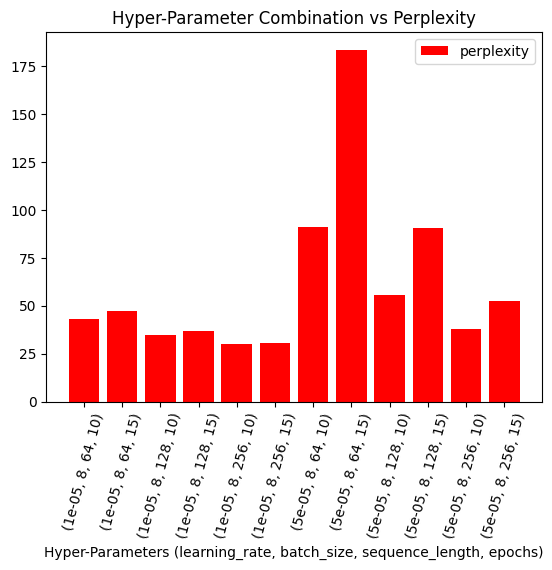

In [114]:
# plotting the graph of the hyper parameter combination to the perplexity of the models
from matplotlib import pyplot as plt
plt.bar([str(a) for a in loss_dataframes['hyper_parameter_combinations']], loss_dataframes['perplexity'], color = 'red', label='perplexity')
plt.xticks(rotation = 75)
plt.xlabel('Hyper-Parameters (learning_rate, batch_size, sequence_length, epochs)')
plt.title('Hyper-Parameter Combination vs Perplexity')
plt.legend()
plt.show()

In [ ]:
print(min_perplexity)

tf.Tensor(29.87916, shape=(), dtype=float32)


In [ ]:
best_combination = hyper_parameter_combinations[all_perplexity.index(min_perplexity)]
best_combination

(1e-05, 8, 256, 10)

In [ ]:
# storing the training history of the model which gave the lowest perplexity
best_model_training_history = all_histories[all_perplexity.index(min_perplexity)]
history_df = best_model_training_history.history
history_df = pd.DataFrame(history_df)
history_df.to_csv('best_model_training_history.csv')

<Axes: >

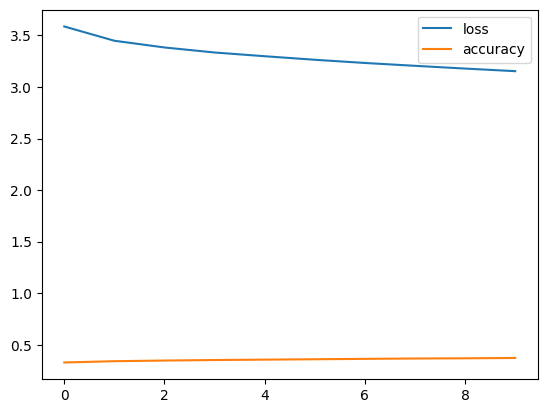

In [105]:
history_df.plot()

In [ ]:
# selecting the model which gave the lowest perplexity
best_model = all_models[all_perplexity.index(min_perplexity)]

In [ ]:
best_model.save('best_gpt2_model')

In [102]:
def story_generation(prompt, temp):
    """
    Generates text using the trained GPT2 model.

    Arguments: 
        prompt(str): the initial seed text for the generation
        temp(float): to determine the randomness of the generation
    Return:
        generated_text(str): story generated by the GPT2 model
    """
    input_ids = tokenizer.encode(prompt, return_tensors='tf')
    output = best_model.generate(input_ids = input_ids, max_length = 100,num_beams = 5, no_repeat_ngram_size=2, do_sample = True, early_stopping=True, temperature = temp)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text


In [103]:
# checking with different temperature parameter value for generation
temperature_values = [ 1.0, 1.5, 2.0, 3.0]
generated_texts = [story_generation('pain\n It may be ', temp) for temp in temperature_values]
print(generated_texts)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

['pain\n It may be \nthe most beautiful day of my life, but I am afraid it is not going to be for you. I do not know what I will do if I see you again. It is been so long since I last saw you, and I have not seen you in a long time. You are the only one I know that I care about. But I cannot let you go, no matter how hard I try. What I want is you to see me again,', 'pain\n It may be icky but ive never felt ick in my life. \nI wish I could change that. It is the only thing I can do right now. I do not think that I will ever have the chance to make a difference, even if I have to go back to my old school and do something about it. This is what happened to me when I was about to give up hope of a brighter future and live in a world full of peace and love', 'pain\n It may be \nthe last day of my life, but then again, I had expected it. I was not here to tell them my real name, not when it would make sense to me; they had decided not to. This time though, all that was important had to be t

In [104]:
text_gen_df = pd.DataFrame(temperature_values, columns =['temperature'])
text_gen_df['generated_text'] = generated_texts
text_gen_df.to_csv('generated_text_temperature_comparison.csv')
text_gen_df

,temperature,generated_text
0,1.0,pain\n It may be \nthe most beautiful day of m...
1,1.5,pain\n It may be icky but ive never felt ick i...
2,2.0,"pain\n It may be \nthe last day of my life, bu..."
3,3.0,pain\n It may be \nThe cold blood that seeps o...


In [115]:
# loging in to HuggingFace profile
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [120]:
# saving the model to the HuggingFace hub
best_model.push_to_hub('aakash-mahesha/fan-story-generation-gpt2-mini')
tokenizer.push_to_hub('aakash-mahesha/fan-story-generation-gpt2-mini')

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

tf_model.h5:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aakash-mahesha/fan-story-generation-gpt2-mini/commit/f667fbd07d1ebc1813c705b3f6fc312542d194bf', commit_message='Upload tokenizer', commit_description='', oid='f667fbd07d1ebc1813c705b3f6fc312542d194bf', pr_url=None, pr_revision=None, pr_num=None)